#### Introduction


Problem Statement

Humans communicate through a combination of verbal and nonverbal cues. Facial expressions, body language, and tone of voice all play a significant role in conveying emotions and intentions. Recent advances in deep learning have shown promise in the development of models that can automatically detect and classify these nonverbal cues.

Existing research has demonstrated that such models can achieve accuracy rates of up to 65-75% in identifying emotions from facial expressions. This is a significant development, as even humans often struggle to accurately interpret the emotions of others.

The proposed research will investigate the feasibility of developing a deep learning model that can detect and classify a wider range of nonverbal cues, including body language and tone of voice. The model will be trained on a large dataset of labeled data and will employ convolutional neural networks (CNNs) to extract features from the data. Pre-trained models will also be leveraged to improve the accuracy of the model.

This research has the potential to revolutionize the way humans interact with machines. By enabling machines to understand nonverbal communication, we can create more natural and intuitive interfaces for a variety of applications.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

#### Exploring and visualizing the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the data from the CSV file
#file_path = '/mnt/data/my_emotion_train.csv'  # Path to your CSV file
data = pd.read_csv("/content/drive/MyDrive/my_emotion_train.csv")

In [4]:
data.head()

,id,emotion,pixels
0,9415,6,29 16 18 18 18 20 19 18 17 17 17 18 17 18 17 1...
1,19109,3,126 154 167 181 188 194 195 194 196 195 198 20...
2,21523,2,169 220 218 208 184 144 72 73 143 183 203 210 ...
3,2076,3,60 64 72 80 83 83 80 82 89 106 114 125 125 127...
4,13957,3,174 148 121 97 78 70 62 57 54 54 42 58 40 64 1...


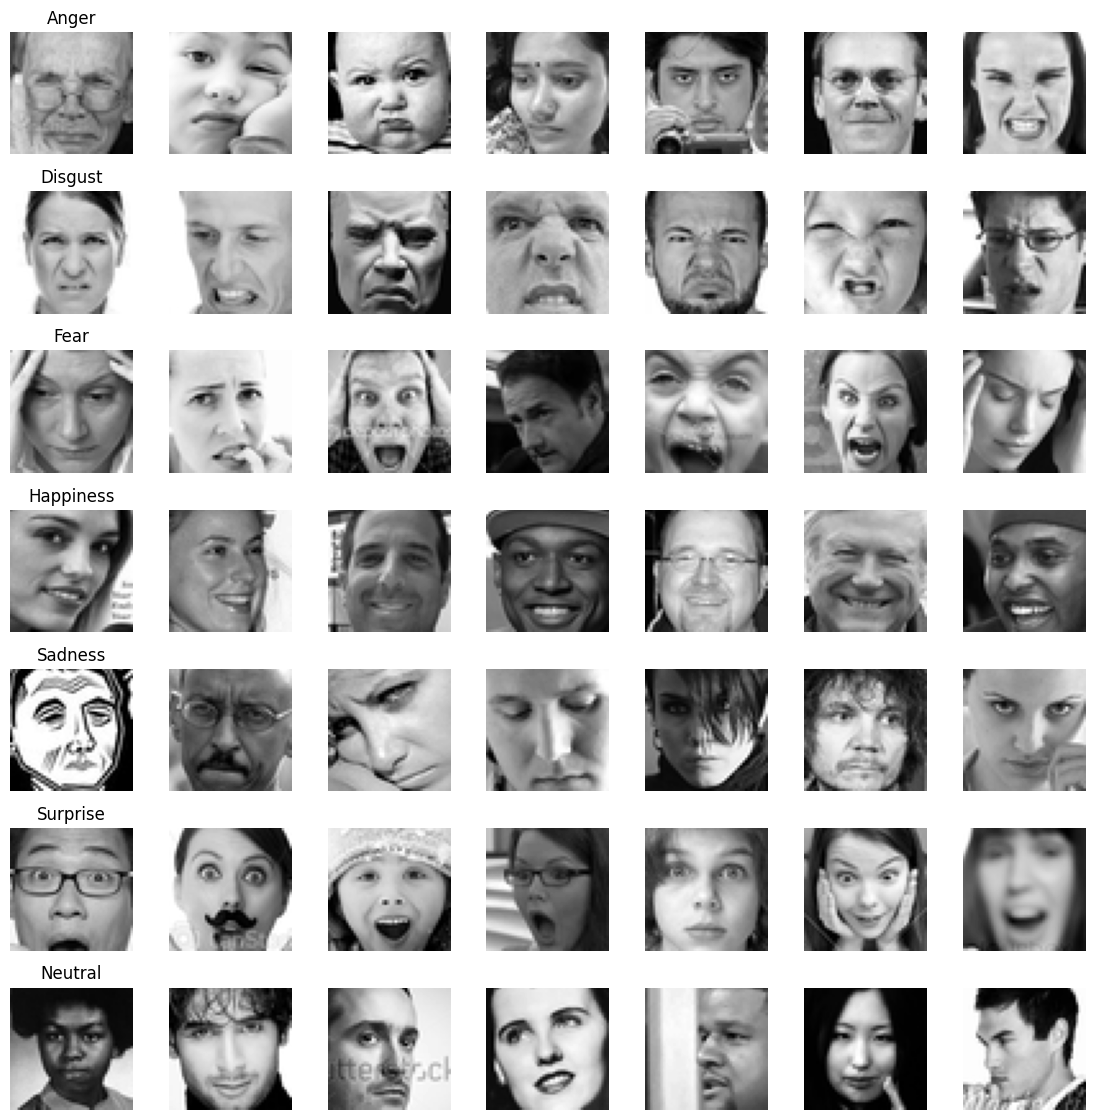

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#  df_emotion is  dataframe and it contains 'emotion' and 'pixels' columns
emotion_label_to_text = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}

# Create subplots of images to visualize insights on training data
fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(14, 14))
fig.subplots_adjust(hspace=0.3)

# Loop through each emotion label and plot sample images
for i, (label, group) in enumerate(data.groupby('emotion')):
    for j in range(7):
        # Safely get the j-th image or the last if not enough images
        sample_image = group['pixels'].iloc[min(j, len(group) - 1)].split(' ')
        pixels = np.array(sample_image, dtype=np.uint8).reshape(48, 48)
        axs[i, j].imshow(pixels, cmap='gray')
        axs[i, j].axis('off')  # Hide the axis
        if j == 0:
            axs[i, j].set_title(emotion_label_to_text[label])

plt.show()


We can observe that this dataset contains misclassified data, i.e., where the labels do not connote the matching expression. In this instance, we will employ some feature extraction and downsampling techniques before we build the model. Now, it is not possible to visualize all the rows given the computation and processing limitations of the system. However, the sample data also provides a clear illustration of how this dataset is structured and labeled. It will be challenging to identify correctly labeled images and use them for building the model.

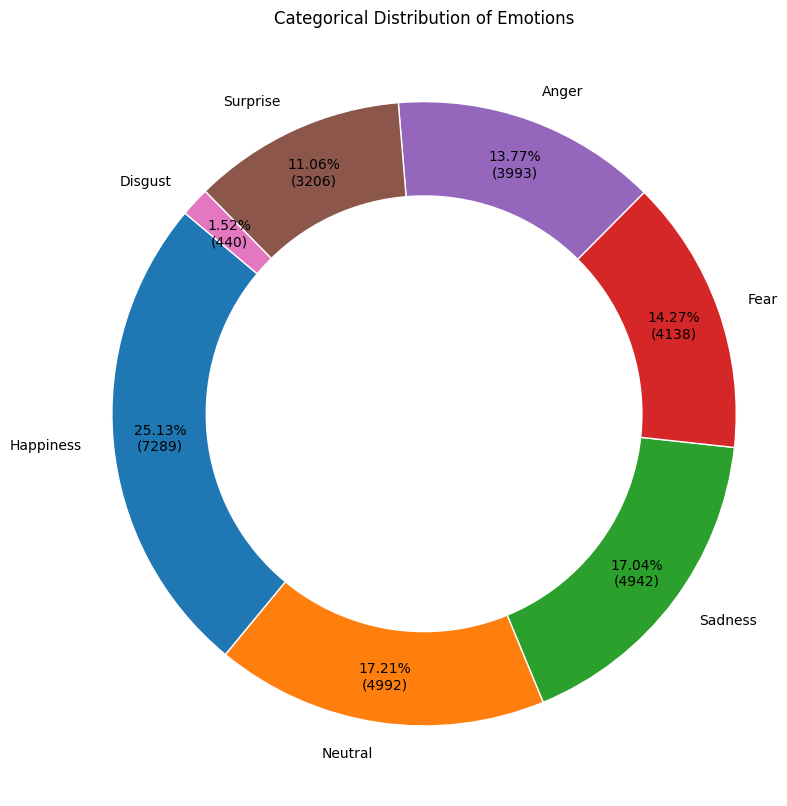

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


emotion_counts = data['emotion'].replace(emotion_label_to_text).value_counts()


def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_format

# Plotting the pie chart with adjusted label positions
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct=autopct_format(emotion_counts),
        startangle=140, pctdistance=0.85, wedgeprops=dict(width=0.5, edgecolor='w'))

# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.tight_layout()

plt.title('Categorical Distribution of Emotions')
plt.show()



Analysis of the provided dataset reveals a distribution of emotions with happiness being the most dominant emotion at 25.13%.  This is followed by sadness (17.21%), fear (14.27%), and anger (13.77%). Disgust emerges as the least frequent emotion at 11.06%.  Surprise represents a minor portion of the dataset at only 1.52%.  This analysis highlights a clear dominance of happiness within the provided data.

#### Model strategy

Baseline model

The RandomForestClassifier is particularly effective for emotional recognition due to its robust handling of complex and heterogeneous data, which is common in datasets involving human emotions. This ensemble method, which constructs multiple decision trees to improve classification accuracy and control overfitting, is well-suited for deciphering the subtle patterns and variations in emotional data. Its capability to aggregate diverse decision paths reduces the likelihood of misinterpretation of emotional cues, making it a reliable choice for applications that require high precision in emotion analysis.

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/my_emotion_train.csv')
X = train_df['pixels'].str.split(' ').apply(lambda x: [int(pixel) for pixel in x])
X = pd.DataFrame(X.tolist(), index=train_df.index)
y = train_df['emotion']

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Initialize and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict on the validation set
y_pred = clf.predict(X_val_scaled)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Baseline Model Accuracy: {accuracy}')

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the test dataset
test_df = pd.read_csv('/content/drive/MyDrive/my_emotion_test.csv')
X_test = test_df['pixels'].str.split(' ').apply(lambda x: [int(pixel) for pixel in x])
X_test = pd.DataFrame(X_test.tolist(), index=test_df.index)

X_test_scaled = scaler.transform(X_test)

# Predict emotions on the test set
y_pred_test = clf.predict(X_test_scaled)

# Create a DataFrame with 'id' and the predicted 'emotion'
results_df = pd.DataFrame({
    'id': test_df['id'],
    'emotion': y_pred_test
})

# Save the DataFrame to a new CSV file
results_df.to_csv('predicted_emotions.csv', index=False)


Baseline Model Accuracy: 0.4510344827586207


<ipython-input-9-232d8a0d5c8e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


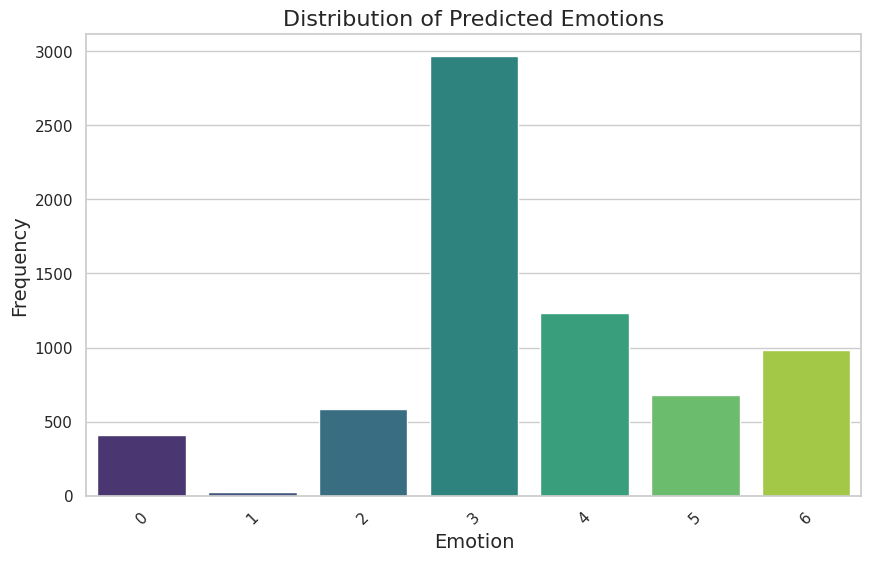

In [9]:
import seaborn as sns

# Count the occurrence of each emotion
emotion_counts = results_df['emotion'].value_counts()

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')

# Add titles and labels
plt.title('Distribution of Predicted Emotions', fontsize=16)
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)  # Rotate labels to improve readability

# Show the plot
plt.show()


The graph depicts the distribution of predicted emotions classified by a CNN model. The x-axis represents the various emotions predicted, and the y-axis indicates the corresponding frequency of each emotion. This suggests a bias in the model's predictions towards certain emotions over others

CNN model

Convolutional Neural Networks (CNNs) are exceptionally suited for emotional recognition tasks, particularly when analyzing visual content like facial expressions. CNNs excel in capturing spatial hierarchies in images by applying convolutional filters that process data through multiple layers, effectively identifying and synthesizing local features into global patterns. This ability to recognize subtle visual cues is crucial in emotional recognition, where nuances in facial expressions can significantly alter the perceived emotion. The layered architecture of CNNs allows for the progressive abstraction of visual details, making it highly effective for tasks that require the interpretation of complex, multidimensional data inherent in human emotions. This makes CNNs indispensable for applications demanding accurate and nuanced emotion analysis.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Load the data from the CSV file
#file_path = '/mnt/data/my_emotion_train.csv'
data = pd.read_csv("/content/drive/MyDrive/my_emotion_train.csv")

# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data['pixels'] = data['pixels'].apply(lambda x: np.fromstring(x, sep=' ').reshape(48, 48, 1)).tolist()
X = np.array(data['pixels'].tolist())
X = X / 255.0  # Normalize pixel values to be between 0 and 1

# Convert the 'emotion' column into one-hot encoded labels
y = pd.get_dummies(data['emotion']).values

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X = np.array(data['pixels'].tolist())
X = X / 255.0  # Normalize pixel values

# Move the channel dimension to the second position (PyTorch format)
X = np.transpose(X, (0, 3, 1, 2))

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)


# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the CNN model
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)  # Dropout
        self.fc1 = nn.Linear(128 * 6 * 6, 1024)
        self.fc2 = nn.Linear(1024, 7)  # Assuming 7 emotions

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 6 * 6)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = EmotionCNN()


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified)
for epoch in range(3): # Number of epochs
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    import numpy as np
import torch
from torchvision import transforms

def preprocess(pixel_strings, image_size=(48, 48)):

    # Convert pixel strings to a NumPy array
    images = np.array([np.fromstring(pixels, dtype=np.float32, sep=' ') for pixels in pixel_strings])
    # Normalize pixel values to [0, 1]
    images /= 255.0
    # Reshape to (N, 1, height, width) for grayscale images
    images = images.reshape(-1, 1, *image_size)
    # Convert to tensor
    images_tensor = torch.tensor(images, dtype=torch.float32)
    return images_tensor


import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Assuming each row in the 'pixels' column is a space-separated string of pixel values
        image = np.fromstring(self.dataframe.iloc[idx]['pixels'], sep=' ', dtype=np.float32)
        image = image.reshape(48, 48)  # Reshape the image (adjust the shape as needed)

        if self.transform:
            image = self.transform(image)

        return image, self.dataframe.iloc[idx]['id']


test_data = pd.read_csv('/content/drive/MyDrive/my_emotion_test.csv')

# Define transformations (if necessary)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create a CustomDataset and DataLoader
test_dataset = CustomDataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = model.to(device)
model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Append predictions with IDs
        predictions.extend(zip(ids.numpy(), predicted.cpu().numpy()))

import pandas as pd

# Assuming 'predictions' in our list of tuples (id, predicted_emotion)
predictions_df = pd.DataFrame(predictions, columns=['id', 'emotion'])


predictions_df.to_csv('CNNpredictions.csv', index=False)


Epoch 1, Loss: 1.7073464393615723
Epoch 2, Loss: 1.6277620792388916
Epoch 3, Loss: 1.6357824802398682


Resnet

ResNet, or Residual Network, is a powerful architecture for deep learning, particularly advantageous for emotional recognition from images. ResNet's defining feature is its use of residual blocks that enable the training of much deeper networks by using skip connections, or shortcuts to jump over some layers. These connections help prevent the vanishing gradient problem, preserving the gradient flow through the network and allowing it to learn more robust features at scale without degrading performance.

For emotional recognition, the depth and complexity of ResNet make it highly effective. It can capture intricate details and subtle emotional expressions in facial features, which are often lost in shallower networks. This deep feature extraction capability makes ResNet particularly suitable for handling the nuanced variations and complexities associated with human emotions, enhancing its ability to perform accurate and sensitive emotion detection. This architecture is, therefore, a preferred choice in advanced applications that require precise interpretation of emotional states from visual data.

In [14]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Load the data from the CSV file
#file_path = '/mnt/data/my_emotion_train.csv'  # Path to your CSV file
data = pd.read_csv("/content/drive/MyDrive/my_emotion_train.csv")

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Convert the 'pixels' column into numpy arrays and reshape into 48x48 (if 48x48 is the correct size)
data['pixels'] = data['pixels'].apply(lambda x: np.fromstring(x, sep=' ').reshape(48, 48, 1)).tolist()
X = np.array(data['pixels'].tolist())
X = X / 255.0  # Normalize pixel values to be between 0 and 1

# Convert the 'emotion' column into one-hot encoded labels
y = pd.get_dummies(data['emotion']).values

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# Custom transformation to convert grayscale to RGB


class GrayscaleToRGBTransform:
    def __call__(self, img):
        # Assume img is [H, W, C]; we transpose it to [C, H, W]
        img = img.permute(2, 0, 1).to(device)  # Adjust from [H, W, C] to [C, H, W]
        return img.repeat(3, 1, 1)  # Then repeat the channel to simulate RGB


# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:

            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.images)


# Apply the grayscale to RGB transformation
transform = GrayscaleToRGBTransform()

# Create  dataset and dataloader
dataset = CustomDataset(X_tensor, y_tensor, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Custom ResNet model for emotion classification
class EmotionResNet(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        # Modify the last layer to fit the number of classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize the model
model = EmotionResNet(num_classes=7).to(device)

# Define  loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize a list to store the loss history
loss_history = []

# Split  dataset into training and validation sets if you haven't done so already
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_corrects = torch.tensor(0)
val_corrects = torch.tensor(0)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(5):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_corrects = 0

    # Training Phase
    for inputs, labels in train_loader:
        # ... (your existing training code)
        inputs, labels = inputs, labels.to(device)
        # Ensure labels are class indices, not one-hot if they are one-hot encoded
        if labels.ndimension() > 1:
            _, labels = torch.max(labels, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_corrects += torch.sum(preds == labels)

    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_acc = train_corrects.double() / len(train_loader.dataset)

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs, labels

            # Ensure labels are class indices
            if labels.ndimension() > 1:
                _, labels = torch.max(labels, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = val_corrects.double() / len(val_loader.dataset)


    # Storing metrics in the history dictionary
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f'Epoch {epoch+1}/{5}')
    print(f'Train loss: {epoch_train_loss}, Accuracy: {epoch_train_acc}')
    print(f'Validation loss: {epoch_val_loss}, Accuracy: {epoch_val_acc}')

# After the training loop:
print("History:", history)

# To check the lengths of the lists:
print("Length of training loss history:", len(history['train_loss']))
print("Length of validation loss history:", len(history['val_loss']))
print("Length of training accuracy history:", len(history['train_acc']))
print("Length of validation accuracy history:", len(history['val_acc']))

# Load test data
test_data = pd.read_csv("/content/drive/MyDrive/my_emotion_test.csv")
test_data['pixels'] = test_data['pixels'].apply(lambda x: np.fromstring(x, sep=' ').reshape(48, 48, 1)).tolist()
X_test = np.array(test_data['pixels'].tolist())
X_test = X_test / 255.0  # Normalize pixel values
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Prepare ID array for output
ids = test_data['id'].values

# Save the model's state dictionary
torch.save(model.state_dict(), 'emotion_resnet_model.pth')


# Assuming you have already defined a transformation
class TestDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.images)

# Create test dataset and dataloader
test_dataset = TestDataset(X_test_tensor, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


#  'data' in our training dataframe and contains an 'emotion' column
emotion_labels = data['emotion'].unique()
emotion_labels.sort()

# Ensure the model is in evaluation mode
model.eval()

# Collect all predictions
predictions = []
with torch.no_grad():
    for inputs in test_dataloader:
        inputs = inputs
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        predictions.extend(predicted.cpu().numpy())
# After prediction, ensure tensors are moved to CPU for processing or visualization
predicted = predicted.cpu()
# Use the saved emotion labels to map predictions
predicted_emotions = [emotion_labels[pred] for pred in predictions]

# Combine IDs and predicted emotions into a DataFrame
output = pd.DataFrame({'id': ids, 'emotion': predicted_emotions})

# Save to new CSV file
output.to_csv('my_emotion_predictions.csv', index=False)



Using cpu device


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.5MB/s]


Epoch 1/5
Train loss: 1.439706091223092, Accuracy: 0.4597844827586207
Validation loss: 1.322385678620174, Accuracy: 0.5056896551724138
Epoch 2/5
Train loss: 1.2238212663551857, Accuracy: 0.54125
Validation loss: 1.2909377515727076, Accuracy: 0.5162068965517241
Epoch 3/5
Train loss: 1.1086403015564228, Accuracy: 0.588103448275862
Validation loss: 1.2030867094829165, Accuracy: 0.5632758620689655
Epoch 4/5
Train loss: 1.0198036089436762, Accuracy: 0.6240948275862069
Validation loss: 1.1231460519494683, Accuracy: 0.5824137931034483
Epoch 5/5
Train loss: 0.9148253122691451, Accuracy: 0.6666810344827586
Validation loss: 1.2314279625333588, Accuracy: 0.5617241379310345
History: {'train_loss': [1.439706091223092, 1.2238212663551857, 1.1086403015564228, 1.0198036089436762, 0.9148253122691451], 'train_acc': [0.4597844827586207, 0.54125, 0.588103448275862, 0.6240948275862069, 0.6666810344827586], 'val_loss': [1.322385678620174, 1.2909377515727076, 1.2030867094829165, 1.1231460519494683, 1.2314279

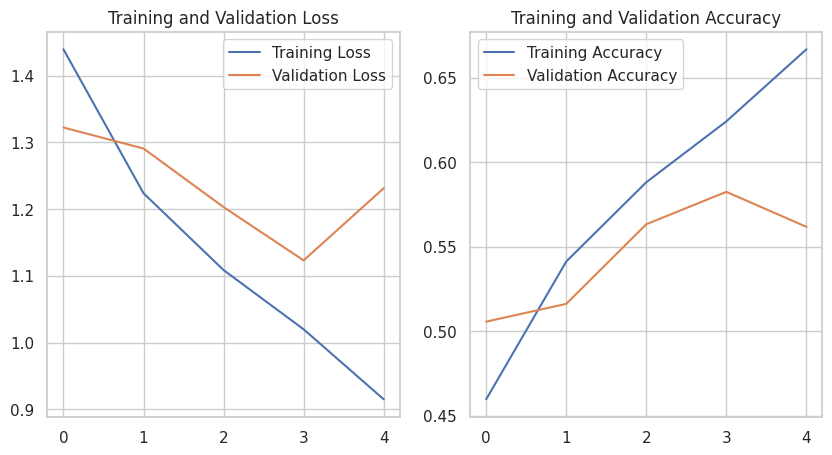

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


The graphs display the training and validation loss and accuracy of a neural network over the course of 5 epochs.

From the 'Loss over epochs' graph, both training and validation loss decrease as the number of epochs increases, with the training loss decreasing more sharply. This indicates the model is learning and improving its performance on the training data, and similarly, albeit to a lesser degree, on the unseen validation data.

The 'Accuracy over epochs' graph shows that the training accuracy increases significantly over time, suggesting that the model is getting better at correctly classifying the training data. However, the validation accuracy also increases but at a slower rate, indicating that the model is learning generalizable patterns to some extent, but there could be a beginning of overfitting to the training data as the gap between training and validation accuracy is widening with more epochs.

#### Conclusion


We commenced our analysis with a RandomForestClassifier, leveraging its robustness in managing diverse and intricate datasets. This foundational approach yielded a respectable score of 0.44 on the Kaggle leaderboard, providing essential insights into our data analysis strategy.

Building upon this, we experimented with a Convolutional Neural Network (CNN). However, the performance was less than optimal, achieving only a score of 0.23 on Kaggle. This underscored potential limitations of CNNs in our specific application context, possibly due to its primary suitability for spatial data analysis rather than the features presented in our dataset.

To address this and further enhance our model’s capability, we transitioned to the ResNet architecture. Known for its deep network capabilities facilitated by residual learning, ResNet significantly improved our performance, achieving the highest score of 0.59 on Kaggle. The advanced feature extraction and learning capabilities of ResNet proved to be highly effective, particularly in handling the complexities associated with our emotional recognition task. This progression highlights the importance of selecting appropriate model architectures based on specific data characteristics and task requirements.